In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.integrate import solve_ivp
from tqdm import tqdm
from scipy.optimize import minimize
import scipy as sp
from scipy.integrate import solve_ivp
import numdifftools as nd

from numpy.linalg import eig

In [2]:
import os
if 'inference-from-testing' in os.getcwd():
    os.chdir("../..")
os.getcwd()

'/Users/user/Documents/GitHub/covid-19-in-households-public'

In [3]:
from copy import deepcopy
from numpy import arange, array, atleast_2d, log
from os import mkdir
from os.path import isdir, isfile
from pickle import load, dump
from pandas import read_csv
from scipy.integrate import solve_ivp
from model.preprocessing import ( estimate_beta_ext, estimate_growth_rate,
        SEIRInput, HouseholdPopulation, make_initial_condition_by_eigenvector)
from model.specs import SINGLE_AGE_SEIR_SPEC_FOR_FITTING, SINGLE_AGE_UK_SPEC
from model.common import SEIRRateEquations
from model.imports import NoImportModel

In [4]:
DOUBLING_TIME = 3
growth_rate = log(2) / DOUBLING_TIME

comp_dist = read_csv(
    'inputs/england_hh_size_dist.csv',
    header=0).to_numpy().squeeze()
comp_dist = comp_dist[:3]
comp_dist[:2] *= 0
comp_dist = comp_dist/sum(comp_dist)
max_hh_size = len(comp_dist)
composition_list = np.atleast_2d(arange(1, max_hh_size+1)).T

#comp_dist = array([1.])
#composition_list = array([[1]])

if isdir('outputs') is False:
    mkdir('outputs')
if isdir('outputs/inference-from-testing') is False:
    mkdir('outputs/inference-from-testing')

SPEC = {**SINGLE_AGE_SEIR_SPEC_FOR_FITTING, **SINGLE_AGE_UK_SPEC}
model_input_to_fit = SEIRInput(SPEC, composition_list, comp_dist)
household_population_to_fit = HouseholdPopulation(
    composition_list, comp_dist, model_input_to_fit)
rhs_to_fit = SEIRRateEquations(model_input_to_fit, household_population_to_fit, NoImportModel(4,2))
beta_ext = estimate_beta_ext(household_population_to_fit, rhs_to_fit, growth_rate)
model_input = deepcopy(model_input_to_fit)
model_input.k_ext *= beta_ext
print('Estimated beta is',beta_ext)


# With the parameters chosen, we calculate Q_int:
household_population = HouseholdPopulation(
    composition_list, comp_dist, model_input)

rhs = SEIRRateEquations(model_input, household_population, NoImportModel(4,1))

r_est = estimate_growth_rate(household_population, rhs, [0.001, 5], 1e-9)


print('Estimated growth rate is',r_est,'.')
print('Estimated doubling time is',log(2) / r_est,'.')

H0 = make_initial_condition_by_eigenvector(growth_rate, model_input, household_population, rhs, 1e-2, 0.0,False,3)
S0 = H0.T.dot(household_population.states[:, ::4])
E0 = H0.T.dot(household_population.states[:, 1::4])
I0 = H0.T.dot(household_population.states[:, 2::4])
R0 = H0.T.dot(household_population.states[:, 3::4])
start_state = (1/model_input.ave_hh_size) * array([S0.sum(),
                                                   E0.sum(),
                                                   I0.sum(),
                                                   R0.sum()])
tspan = (0.0, 365)
print(start_state)

Estimated beta_int= 0.01849526514675815 , estimated density= 0.5452971569851536
Estimated beta is [3.90689101]
converged in 12 iterations.
Estimated growth rate is 0.23104906018672192 .
Estimated doubling time is 2.9999999999990457 .
[0.99 0.01 0.   0.  ]


/Users/user/Documents/GitHub/covid-19-in-households-public/model/preprocessing.py:1190: SparseEfficiencyWarning: spilu converted its input to CSC format
  sA_iLU = spilu(discount_matrix)


In [5]:
comp_dist

array([0., 0., 1.])

In [6]:
composition_list

array([[1],
       [2],
       [3]])

In [7]:
# Now set up evaluation time points and solve system:

# New time at which we evaluate the infection
trange = np.arange(0,7*12,7) # Evaluate for 12 weeks

# Solve:
solution = solve_ivp(rhs, tspan, H0, first_step=0.001, atol=1e-16, t_eval=trange)

time = solution.t
H = solution.y
S = H.T.dot(household_population.states[:, ::4])
E = H.T.dot(household_population.states[:, 1::4])
I = H.T.dot(household_population.states[:, 2::4])
R = H.T.dot(household_population.states[:, 3::4])

/var/folders/mn/cjzm0gtn7_z4bsq7d44zp_y00000gp/T/ipykernel_35526/852802733.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('tab20')


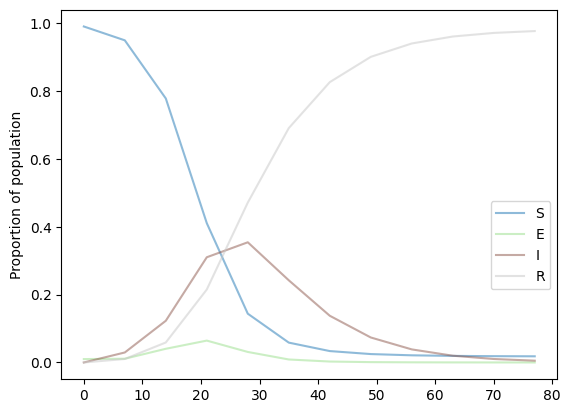

In [8]:
from matplotlib.pyplot import subplots
from matplotlib.cm import get_cmap

data_list = [S/model_input.ave_hh_by_class,
    E/model_input.ave_hh_by_class,
    I/model_input.ave_hh_by_class,
    R/model_input.ave_hh_by_class]

lgd=['S','E','I','R']

fig, (axis) = subplots(1,1, sharex=True)

cmap = get_cmap('tab20')
alpha = 0.5
for i in range(len(data_list)):
    axis.plot(
        time, data_list[i], label=lgd[i],
        color=cmap(i/len(data_list)), alpha=alpha)
axis.set_ylabel('Proportion of population')
axis.legend(ncol=1, bbox_to_anchor=(1,0.50))

In [9]:
H[H<0.0] = 0.0

Make test data for single-household trajectories and calculate LLH

In [10]:
from numpy.random import choice

H0 = make_initial_condition_by_eigenvector(growth_rate, model_input, household_population, rhs, 1e-1, 0.0,False,3)
test_times = np.arange(7,7*12,7)
def generate_single_hh_test_data(test_times):
    Ht = deepcopy(H0)
    test_data = np.zeros((len(test_times),))
    for i in range(len(test_times)-1):
        tspan = (test_times[i], test_times[i+1])
        solution = solve_ivp(rhs, tspan, Ht, first_step=0.001, atol=1e-16)
        time = solution.t
        H = solution.y
        state = choice(range(len(H[:, -1])), 1, p=H[:, -1]/sum(H[:, -1]))
        test_data[i] = rhs.states_inf_only[state]
        Ht *= 0
        Ht[state] = 1
    return(test_data)
sample_data = generate_single_hh_test_data(test_times)
print(sample_data)

[1. 2. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


/var/folders/mn/cjzm0gtn7_z4bsq7d44zp_y00000gp/T/ipykernel_35526/3964832397.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test_data[i] = rhs.states_inf_only[state]


In [11]:
# Log likelihood if we can only measure infecteds
# This is for test results from one household, you´ll need to adapt to multiple

def llh_from_test_data(test_data, test_times, rhs, H0):
    Ht = deepcopy(H0)
    llh = 0
    for i in range(len(test_times)-1):
        if i==0:
            start_time = 0
        else:
            start_time = test_times[i-1]
        tspan = (start_time, test_times[i])
        solution = solve_ivp(rhs, tspan, Ht, first_step=0.001, atol=1e-16)
        time = solution.t
        H = solution.y
        I = test_data[i]
        possible_states = np.where(np.abs(np.sum(rhs.states_inf_only,1)-I)<1e-1)[0]
        llh += np.log(np.sum(H[possible_states, -1]))
        Ht *= 0
        Ht[possible_states] = H[possible_states, -1]
    return(llh)

llh_from_test_data(sample_data, test_times, rhs, H0)

-30.79796959524579

Quick check to make sure the restricted trajectory locks on to the right thing:

In [12]:
# Log likelihood calculation but return probability trajectory

def llh_with_traj(test_data, test_times, rhs, H0):
    Ht = deepcopy(H0)
    H_all = np.atleast_2d(deepcopy(H0)).T
    t_all = np.array(0)
    llh = 0
    for i in range(len(test_times)-1):
        if i==0:
            start_time = 0
        else:
            start_time = test_times[i-1]
        tspan = (start_time, test_times[i])
        solution = solve_ivp(rhs, tspan, Ht, first_step=0.001, atol=1e-16)
        time = solution.t
        H = solution.y
        I = test_data[i]
        possible_states = np.where(np.abs(np.sum(rhs.states_inf_only,1)-I)<1e-1)[0]
        llh += np.log(np.sum(H[possible_states, -1]))
        Ht *= 0
        Ht[possible_states] = H[possible_states, -1]
        Ht = Ht/sum(Ht)
        H_all = np.hstack((H_all, H))
        t_all = np.hstack((t_all, time))
    return(llh, H_all, t_all)

llh, H_all, t_all = llh_with_traj(sample_data, test_times, rhs, H0)

/var/folders/mn/cjzm0gtn7_z4bsq7d44zp_y00000gp/T/ipykernel_35526/32998234.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('tab20')


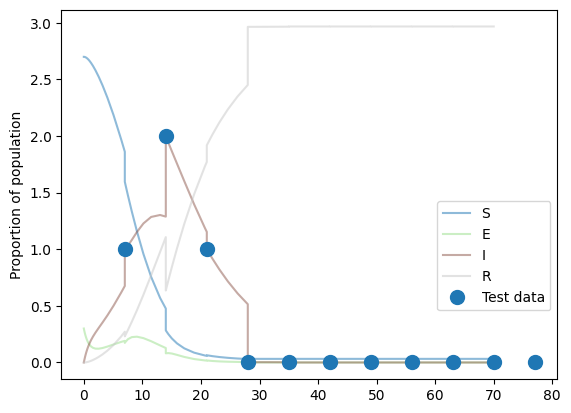

In [13]:
S = H_all.T.dot(household_population.states[:, ::4])
E = H_all.T.dot(household_population.states[:, 1::4])
I = H_all.T.dot(household_population.states[:, 2::4])
R = H_all.T.dot(household_population.states[:, 3::4])

data_list = [S/model_input.ave_hh_by_class,
    E/model_input.ave_hh_by_class,
    I/model_input.ave_hh_by_class,
    R/model_input.ave_hh_by_class]

lgd=['S','E','I','R', "Test data"]

fig, (axis) = subplots(1,1, sharex=True)

cmap = get_cmap('tab20')
alpha = 0.5
for i in range(len(data_list)):
    axis.plot(t_all,
        3*data_list[i], label=lgd[i],
        color=cmap(i/len(data_list)), alpha=alpha)
axis.plot(test_times, sample_data, marker=".", ls="", ms=20, label=lgd[-1])
axis.set_ylabel('Proportion of population')
axis.legend(ncol=1, bbox_to_anchor=(1,0.50))

In [14]:
# Now do multiple households

# Generate test data:
n_hh = 50
multi_hh_data = [generate_single_hh_test_data(test_times) for i in range(n_hh)]

# Option: Only include houses with at least one +ve
# multi_hh_data = [data for data in multi_hh_data if np.sum(data)>0]

/var/folders/mn/cjzm0gtn7_z4bsq7d44zp_y00000gp/T/ipykernel_35526/3964832397.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test_data[i] = rhs.states_inf_only[state]


In [15]:
multi_hh_data

[array([2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([1., 3., 2., 1., 1., 1., 0., 0., 0., 0., 0.]),
 array([1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.]),
 array([1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([2., 2., 2., 2., 1., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([1., 2., 2., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.]),
 array([1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.]),
 array([1., 1., 0., 0., 0., 

In [16]:
# Try a single likelihood calculation

multi_hh_llh = sum(array([llh_from_test_data(sample_data, test_times, rhs, H0) for sample_data in multi_hh_data]))

At this point, we should be able to write a function taking parameters as input and calculating llh for those parameters.

In [17]:
def llh_from_pars(data, test_times, lam, tau):
    model_input = SEIRInput(SPEC, composition_list, comp_dist, print_ests=False)
    model_input.k_home = lam / model_input.beta_int * model_input.k_home
    model_input.k_ext = tau * model_input.k_ext
    # With the parameters chosen, we calculate Q_int:
    household_population = HouseholdPopulation(
        composition_list, comp_dist, model_input)
    
    rhs = SEIRRateEquations(model_input, household_population, NoImportModel(4,1))
    H0 = make_initial_condition_by_eigenvector(growth_rate, model_input, household_population, rhs, 1e-2, 0.0,False,3)
    tspan = (0.0, 365)
    return(sum(array([llh_from_test_data(data, test_times, rhs, H0) for data in multi_hh_data])))

In [18]:
llh_from_pars(multi_hh_data, test_times, 0.015, 4)

-1871.9735362493827

In [19]:
lam_vals = arange(0.01, 0.03, 0.005)
tau_vals = arange(2.0, 5.0, 0.5)
llh_vals = np.zeros((len(lam_vals), len(tau_vals)))
for i in range(len(lam_vals)):
    for j in range(len(tau_vals)):
        print("lam=",lam_vals[i],", tau=",tau_vals[j])
        llh_vals[i,j] = llh_from_pars(multi_hh_data, test_times, lam_vals[i], tau_vals[j])

lam= 0.01 , tau= 2.0
lam= 0.01 , tau= 2.5
lam= 0.01 , tau= 3.0
lam= 0.01 , tau= 3.5
lam= 0.01 , tau= 4.0
lam= 0.01 , tau= 4.5
lam= 0.015 , tau= 2.0
lam= 0.015 , tau= 2.5
lam= 0.015 , tau= 3.0
lam= 0.015 , tau= 3.5
lam= 0.015 , tau= 4.0
lam= 0.015 , tau= 4.5
lam= 0.019999999999999997 , tau= 2.0
lam= 0.019999999999999997 , tau= 2.5
lam= 0.019999999999999997 , tau= 3.0
lam= 0.019999999999999997 , tau= 3.5
lam= 0.019999999999999997 , tau= 4.0
lam= 0.019999999999999997 , tau= 4.5
lam= 0.024999999999999998 , tau= 2.0
lam= 0.024999999999999998 , tau= 2.5
lam= 0.024999999999999998 , tau= 3.0
lam= 0.024999999999999998 , tau= 3.5
lam= 0.024999999999999998 , tau= 4.0
lam= 0.024999999999999998 , tau= 4.5


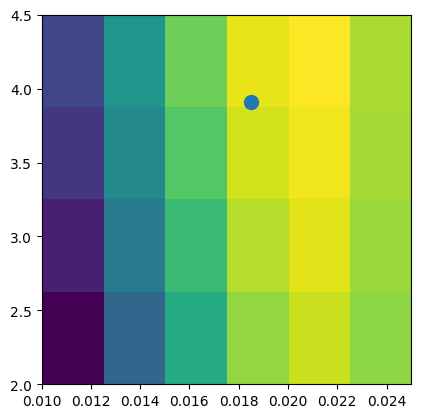

In [20]:
fig, ax = subplots(1, 1)
lam_range = lam_vals[-1] - lam_vals[0]
tau_range = tau_vals[-1] - tau_vals[0]
ax.imshow(llh_vals,
            origin='lower',
            extent=(lam_vals[0],lam_vals[-1],tau_vals[0],tau_vals[-1]),
         aspect=lam_range/tau_range)
ax.plot([model_input.beta_int],
        [beta_ext],
        marker=".",
        ms=20)

lam= 0.01
lam= 0.015
lam= 0.019999999999999997
lam= 0.024999999999999998
tau= 2.0
tau= 2.5
tau= 3.0
tau= 3.5
tau= 4.0
tau= 4.5


Text(0, 0.5, 'log likelihood')

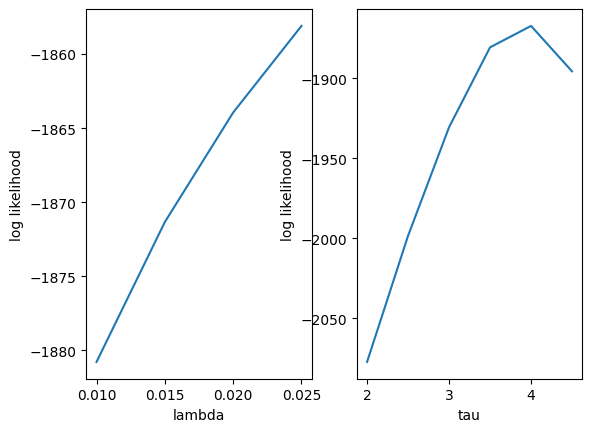

In [21]:
llh_fixed_tau = np.zeros((len(lam_vals),))
for i in range(len(lam_vals)):
    print("lam=",lam_vals[i])
    llh_fixed_tau[i] = llh_from_pars(multi_hh_data, test_times, lam_vals[i], beta_ext)

llh_fixed_lam = np.zeros((len(tau_vals),))
for i in range(len(tau_vals)):
    print("tau=",tau_vals[i])
    llh_fixed_lam[i] = llh_from_pars(multi_hh_data, test_times, model_input.beta_int, tau_vals[i])

fig, (ax1, ax2) = subplots(1, 2)
ax1.plot(lam_vals, llh_fixed_tau)
ax1.set_xlabel("lambda")
ax1.set_ylabel("log likelihood")
ax2.plot(tau_vals, llh_fixed_lam)
ax2.set_xlabel("tau")
ax2.set_ylabel("log likelihood")